In [25]:
### ライブラリのインポート
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

import lightgbm as lgb
import optuna

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [48]:
### 定数の定義
## 検証データの割合
valid_size = 0.3     # 訓練：検証＝7:3

## 入力データ
train_x_file = 'train_x.csv'
train_y_file = 'train_y.csv'
test_x_file = 'test_x.csv'
test_file = 'test.csv'
result_file = 'Titanic_result.csv'

In [26]:
### 混交行列の可視化
def heat_map(cm):
    cm_matrix = pd.DataFrame(data=cm,columns=['Actual Positive:1','Actual Negative:0'],
                            index=['Predict Positive:1','Predict Negative:0'])
    
    # ヒートマップで描画
    plt.figure(figsize=(3, 3))
    heatmap = sns.heatmap(cm_matrix, annot=True, fmt='d',cmap='coolwarm')
    # heatmap.set_title('混同行列',fontsize=20)
    heatmap.set_xticks([0.5,1.5])
    heatmap.set_xlabel('予測',fontsize=15)
    heatmap.set_xticklabels(['Negative:0','Positive:1'],fontsize=12)
    heatmap.set_ylabel('真値',fontsize=15)
    heatmap.set_yticks([0.5,1.5])
    heatmap.set_yticklabels(['Negative:0','Positive:1'],fontsize=12)

In [43]:
### データのインポート
train_x = pd.read_csv('processed_data/' + train_x_file)
train_y = pd.read_csv('processed_data/' + train_y_file)
test_x = pd.read_csv('processed_data/' + test_x_file)
test_data = pd.read_csv('original_data/' + test_file)

In [29]:
### データの分割
x_train, x_valid, y_train, y_valid = train_test_split(
    train_x, train_y,          # 入力とラベル
    test_size=valid_size,             # 検証データの割合（30%）
    random_state=42,           # 乱数シード（再現性のため）
    shuffle=True               # シャッフルして分割（デフォルトTrue）
)

In [32]:
### optunaの準備
## 評価指標はaccuracy
def objective(trial):

    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_test = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
    
    param = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'binary_error'},#binary_error

        'lambda_l1'         : trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2'         : trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),

        'force_col_wise':True,
        'random_state': 0,
        }
    
    
    model = lgb.train(
                    params=param,                    # ハイパーパラメータをセット
                    train_set=lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=1),
                               lgb.log_evaluation(10),],         # アーリーストッピング設定

                    # evals_result=lgb_results,
                    # verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )
    
    # 推論
    pred = model.predict(x_valid, num_iteration=model.best_iteration)
    y_pred = np.where(pred < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す

    # 評価
    #＝＝＝＝＝＝＝＝＝＝＝利用したい評価指標に変更＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
    score = accuracy_score(y_valid, y_pred)

    return score

In [33]:
### optunaの実行
study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=200)

print("=======ベストパラメータ========")
print(study.best_params)

[I 2025-05-21 23:15:17,504] A new study created in memory with name: no-name-70b9511f-5ba1-4b31-b7da-0ffdf983dd45
[I 2025-05-21 23:15:17,573] Trial 0 finished with value: 0.8134328358208955 and parameters: {'lambda_l1': 2.348881295853312e-05, 'lambda_l2': 3.6010467344475385, 'learning_rate': 0.7587945476302645, 'num_leaves': 154, 'feature_fraction': 0.4936111842654619, 'bagging_fraction': 0.49359671220172163, 'bagging_freq': 1, 'min_child_samples': 88}. Best is trial 0 with value: 0.8134328358208955.


[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-05-21 23:15:17,729] Trial 1 finished with value: 0.8171641791044776 and parameters: {'lambda_l1': 0.002570603566117596, 'lambda_l2': 0.02358594058414266, 'learning_rate': 0.1185260448662222, 'num_leaves': 249, 'feature_fraction': 0.899465584480253, 'bagging_fraction': 0.5274034664069657, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 1 with value: 0.8171641791044776.
[I 2025-05-21 23:15:17,824] Trial 2 finished with value: 0.832089552238806 and parameters: {'lambda_l1': 5.472429642032189e-06, 'lambda_l2': 0.00052821153945323, 'learning_rate': 0.4887505167779042, 'num_leaves': 76, 'feature_fraction': 0.7671117368334277, 'bagging_fraction': 0.4836963163912251, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 2 with value: 0.832089552238806.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	Train's binary_error: 0.0898876	Test's binary_error: 0.205224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is

[I 2025-05-21 23:15:17,955] Trial 3 finished with value: 0.8395522388059702 and parameters: {'lambda_l1': 0.00012724181576752517, 'lambda_l2': 0.11656915613247415, 'learning_rate': 0.2797064039425238, 'num_leaves': 133, 'feature_fraction': 0.7554487413172255, 'bagging_fraction': 0.42787024763199866, 'bagging_freq': 5, 'min_child_samples': 21}. Best is trial 3 with value: 0.8395522388059702.
[I 2025-05-21 23:15:18,016] Trial 4 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 3.850031979199519e-08, 'lambda_l2': 3.4671276804481113, 'learning_rate': 0.9690688297671034, 'num_leaves': 208, 'feature_fraction': 0.5827682615040224, 'bagging_fraction': 0.45860326840383037, 'bagging_freq': 5, 'min_child_samples': 47}. Best is trial 3 with value: 0.8395522388059702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train's binary_error: 0.0963082	Test's binary_error: 0.201493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:18,132] Trial 5 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 1.254134495897175e-07, 'lambda_l2': 0.00028614897264046574, 'learning_rate': 0.13094966900369656, 'num_leaves': 233, 'feature_fraction': 0.5552679889600102, 'bagging_fraction': 0.7975133706123891, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 3 with value: 0.8395522388059702.
[I 2025-05-21 23:15:18,181] Trial 6 finished with value: 0.8097014925373134 and parameters: {'lambda_l1': 0.0008325158565947969, 'lambda_l2': 4.609885087947832e-07, 'learning_rate': 0.9726261649881027, 'num_leaves': 199, 'feature_fraction': 0.9636993649385135, 'bagging_fraction': 0.9368964102565893, 'bagging_freq': 5, 'min_child_samples': 93}. Best is trial 3 with value: 0.8395522388059702.
[I 2025-05-21 23:15:18,314] Trial 7 finished with value: 0.835820895522388 and parameters: {'lambda_l1': 6.257956190096665e-08, 'lambda_l2': 5.805581976088804e-07, 'learning_rate': 0.14070456001948425, 'num_lea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	Train's binary_error: 0.125201	Test's binary_error: 0.201493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:18,512] Trial 8 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 3.3760633488778465e-06, 'lambda_l2': 0.0007660634613082907, 'learning_rate': 0.2268318024772864, 'num_leaves': 206, 'feature_fraction': 0.44473038620786254, 'bagging_fraction': 0.9921321619603104, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 3 with value: 0.8395522388059702.


[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-05-21 23:15:18,644] Trial 9 finished with value: 0.832089552238806 and parameters: {'lambda_l1': 1.1212412169964432e-08, 'lambda_l2': 0.21834982897607286, 'learning_rate': 0.7361716094628554, 'num_leaves': 187, 'feature_fraction': 0.8627622080115674, 'bagging_fraction': 0.44442679104045424, 'bagging_freq': 3, 'min_child_samples': 16}. Best is trial 3 with value: 0.8395522388059702.
[I 2025-05-21 23:15:18,706] Trial 10 finished with value: 0.8171641791044776 and parameters: {'lambda_l1': 1.9921468465209982, 'lambda_l2': 1.1323342574941986e-08, 'learning_rate': 0.37692479030523596, 'num_leaves': 6, 'feature_fraction': 0.7393678544088419, 'bagging_fraction': 0.6560877372299885, 'bagging_freq': 7, 'min_child_samples': 6}. Best is trial 3 with value: 0.8395522388059702.


Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train's binary_error: 0.133226	Test's binary_error: 0.182836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-05-21 23:15:18,792] Trial 11 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 0.05034404362321346, 'lambda_l2': 5.651980396882272e-06, 'learning_rate': 0.32141334787017717, 'num_leaves': 92, 'feature_fraction': 0.6443358290341519, 'bagging_fraction': 0.6123369175431512, 'bagging_freq': 7, 'min_child_samples': 67}. Best is trial 3 with value: 0.8395522388059702.


[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-05-21 23:15:18,919] Trial 12 finished with value: 0.8395522388059702 and parameters: {'lambda_l1': 6.982496886163948e-05, 'lambda_l2': 4.647511129008785e-06, 'learning_rate': 0.3037746208381966, 'num_leaves': 103, 'feature_fraction': 0.6753187515965878, 'bagging_fraction': 0.5783076007698265, 'bagging_freq': 5, 'min_child_samples': 32}. Best is trial 3 with value: 0.8395522388059702.
[I 2025-05-21 23:15:19,021] Trial 13 finished with value: 0.832089552238806 and parameters: {'lambda_l1': 0.020439174832649107, 'lambda_l2': 5.1972857326459374e-05, 'learning_rate': 0.4788743881864154, 'num_leaves': 129, 'feature_fraction': 0.7906094819029569, 'bagging_fraction': 0.7560523377124633, 'bagging_freq': 5, 'min_child_samples': 31}. Best is trial 3 with value: 0.8395522388059702.


[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-05-21 23:15:19,325] Trial 14 finished with value: 0.8059701492537313 and parameters: {'lambda_l1': 5.602431652908587e-05, 'lambda_l2': 0.014421956473996984, 'learning_rate': 0.31847108598306784, 'num_leaves': 37, 'feature_fraction': 0.6790461525769751, 'bagging_fraction': 0.4133175277797147, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 3 with value: 0.8395522388059702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	Train's binary_error: 0.05939	Test's binary_error: 0.238806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2025-05-21 23:15:19,416] Trial 15 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 0.00017852740646811646, 'lambda_l2': 0.01889174545843545, 'learning_rate': 0.602918724738983, 'num_leaves': 136, 'feature_fraction': 0.8344376716296752, 'bagging_fraction': 0.5842960944883594, 'bagging_freq': 4, 'min_child_samples': 32}. Best is trial 3 with value: 0.8395522388059702.
[I 2025-05-21 23:15:19,511] Trial 16 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 0.009176010172526138, 'lambda_l2': 1.4577898537336529e-05, 'learning_rate': 0.2515433188551086, 'num_leaves': 113, 'feature_fraction': 0.9971369131732215, 'bagging_fraction': 0.74950652934642, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 3 with value: 0.8395522388059702.


[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-05-21 23:15:19,583] Trial 17 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 1.9451598888023945e-06, 'lambda_l2': 1.1939309049320637e-08, 'learning_rate': 0.4200635973467216, 'num_leaves': 56, 'feature_fraction': 0.7197707746305592, 'bagging_fraction': 0.669980471556721, 'bagging_freq': 5, 'min_child_samples': 62}. Best is trial 3 with value: 0.8395522388059702.
[I 2025-05-21 23:15:19,689] Trial 18 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 0.6849391813641037, 'lambda_l2': 8.932161985598004e-07, 'learning_rate': 0.5705984939063657, 'num_leaves': 163, 'feature_fraction': 0.5706578792951973, 'bagging_fraction': 0.5384913454276177, 'bagging_freq': 4, 'min_child_samples': 15}. Best is trial 3 with value: 0.8395522388059702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.17175	Test's binary_error: 0.179104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2025-05-21 23:15:19,797] Trial 19 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 6.939491904069986e-07, 'lambda_l2': 0.1454821990467753, 'learning_rate': 0.2147588799430072, 'num_leaves': 112, 'feature_fraction': 0.6907586896905884, 'bagging_fraction': 0.8476829858837607, 'bagging_freq': 6, 'min_child_samples': 83}. Best is trial 3 with value: 0.8395522388059702.
[I 2025-05-21 23:15:19,878] Trial 20 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 0.13002154546039094, 'lambda_l2': 0.002487863600367097, 'learning_rate': 0.29395331278483994, 'num_leaves': 171, 'feature_fraction': 0.805665985268239, 'bagging_fraction': 0.41958849553093286, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 3 with value: 0.8395522388059702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.142857	Test's binary_error: 0.186567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:19,997] Trial 21 finished with value: 0.8395522388059702 and parameters: {'lambda_l1': 3.72580315032565e-07, 'lambda_l2': 5.968417776295751e-07, 'learning_rate': 0.1768468320733277, 'num_leaves': 86, 'feature_fraction': 0.6223764612638083, 'bagging_fraction': 0.5861775296742043, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 3 with value: 0.8395522388059702.
[I 2025-05-21 23:15:20,121] Trial 22 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 2.367582623304772e-05, 'lambda_l2': 1.3539873039646844e-07, 'learning_rate': 0.19487574760764073, 'num_leaves': 51, 'feature_fraction': 0.6280300913928896, 'bagging_fraction': 0.6270202057092092, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 3 with value: 0.8395522388059702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.131621	Test's binary_error: 0.175373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:20,250] Trial 23 finished with value: 0.8395522388059702 and parameters: {'lambda_l1': 0.000308333708107415, 'lambda_l2': 5.801963496247614e-06, 'learning_rate': 0.39200291337037146, 'num_leaves': 104, 'feature_fraction': 0.5131087498438186, 'bagging_fraction': 0.7070916823253007, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 3 with value: 0.8395522388059702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train's binary_error: 0.130016	Test's binary_error: 0.160448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:20,345] Trial 24 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 3.1400780400832577e-07, 'lambda_l2': 4.791291738079216e-05, 'learning_rate': 0.31663698499922954, 'num_leaves': 137, 'feature_fraction': 0.6759860892750655, 'bagging_fraction': 0.5066618133063834, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 3 with value: 0.8395522388059702.
[I 2025-05-21 23:15:20,505] Trial 25 finished with value: 0.832089552238806 and parameters: {'lambda_l1': 7.530608113826192e-05, 'lambda_l2': 7.847973586357047e-08, 'learning_rate': 0.6639402717273303, 'num_leaves': 65, 'feature_fraction': 0.4086363521759659, 'bagging_fraction': 0.5770848846618818, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial 3 with value: 0.8395522388059702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[34]	Train's binary_error: 0.138042	Test's binary_error: 0.179104
[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-05-21 23:15:20,605] Trial 26 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 0.0011370801368869303, 'lambda_l2': 2.0659414655007845e-06, 'learning_rate': 0.4913160090015536, 'num_leaves': 29, 'feature_fraction': 0.7424484728521415, 'bagging_fraction': 0.7105062903141457, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 3 with value: 0.8395522388059702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.128411	Test's binary_error: 0.19403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	Train's binary_error: 0.110754

[I 2025-05-21 23:15:20,771] Trial 27 finished with value: 0.8395522388059702 and parameters: {'lambda_l1': 9.292351371072202e-06, 'lambda_l2': 7.51918462815187e-05, 'learning_rate': 0.17985470395029465, 'num_leaves': 98, 'feature_fraction': 0.6103731642059171, 'bagging_fraction': 0.6091801072089511, 'bagging_freq': 7, 'min_child_samples': 22}. Best is trial 3 with value: 0.8395522388059702.
[I 2025-05-21 23:15:20,899] Trial 28 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 1.0992892332001768e-06, 'lambda_l2': 5.865523333637814e-08, 'learning_rate': 0.2673432886581048, 'num_leaves': 116, 'feature_fraction': 0.530256185958059, 'bagging_fraction': 0.5407468333543596, 'bagging_freq': 5, 'min_child_samples': 29}. Best is trial 3 with value: 0.8395522388059702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train's binary_error: 0.0834671	Test's binary_error: 0.190299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	Train's binary_error: 0.0802568	Test's binary_error: 0.212687
[LightGBM] [Warning] No further splits wi

[I 2025-05-21 23:15:20,988] Trial 29 finished with value: 0.8134328358208955 and parameters: {'lambda_l1': 1.9478761650112174e-05, 'lambda_l2': 8.24145801361266, 'learning_rate': 0.3803401941100095, 'num_leaves': 145, 'feature_fraction': 0.471645973649337, 'bagging_fraction': 0.48440179071190764, 'bagging_freq': 2, 'min_child_samples': 56}. Best is trial 3 with value: 0.8395522388059702.
[I 2025-05-21 23:15:21,077] Trial 30 finished with value: 0.8395522388059702 and parameters: {'lambda_l1': 0.003008553991943034, 'lambda_l2': 0.7498650945882516, 'learning_rate': 0.4528771709885607, 'num_leaves': 160, 'feature_fraction': 0.886461872138135, 'bagging_fraction': 0.6453834507881886, 'bagging_freq': 1, 'min_child_samples': 45}. Best is trial 3 with value: 0.8395522388059702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.149278	Test's binary_error: 0.197761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train's binary_error: 0.15730

[I 2025-05-21 23:15:21,216] Trial 31 finished with value: 0.832089552238806 and parameters: {'lambda_l1': 0.00031383660223193566, 'lambda_l2': 3.032562951615104e-06, 'learning_rate': 0.366292486710351, 'num_leaves': 100, 'feature_fraction': 0.5200287221209342, 'bagging_fraction': 0.7025738266966812, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 3 with value: 0.8395522388059702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	Train's binary_error: 0.0866774	Test's binary_error: 0.197761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:21,409] Trial 32 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 9.748108643235224e-05, 'lambda_l2': 1.5551803574551055e-05, 'learning_rate': 0.10931359507218652, 'num_leaves': 74, 'feature_fraction': 0.48600998554867325, 'bagging_fraction': 0.8302632556082805, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 3 with value: 0.8395522388059702.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.102729	Test's binary_error: 0.19403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2025-05-21 23:15:21,661] Trial 33 finished with value: 0.8134328358208955 and parameters: {'lambda_l1': 0.0004806786655873123, 'lambda_l2': 2.3323945154547867e-07, 'learning_rate': 0.2645261729046482, 'num_leaves': 118, 'feature_fraction': 0.6666956784269557, 'bagging_fraction': 0.726227561393147, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 3 with value: 0.8395522388059702.
[I 2025-05-21 23:15:21,752] Trial 34 finished with value: 0.8470149253731343 and parameters: {'lambda_l1': 0.004148487479498802, 'lambda_l2': 9.45502019702345e-06, 'learning_rate': 0.8640403234431979, 'num_leaves': 99, 'feature_fraction': 0.5976818924363599, 'bagging_fraction': 0.5012346041921147, 'bagging_freq': 5, 'min_child_samples': 27}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's binary_error: 0.0417335	Test's binary_error: 0.216418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:21,823] Trial 35 finished with value: 0.8022388059701493 and parameters: {'lambda_l1': 0.00420145059733752, 'lambda_l2': 0.0015645949025161, 'learning_rate': 0.9029906878466739, 'num_leaves': 86, 'feature_fraction': 0.5992192726930707, 'bagging_fraction': 0.4567585531097016, 'bagging_freq': 5, 'min_child_samples': 38}. Best is trial 34 with value: 0.8470149253731343.
[I 2025-05-21 23:15:21,883] Trial 36 finished with value: 0.7985074626865671 and parameters: {'lambda_l1': 0.24868383920609052, 'lambda_l2': 0.00011151929147313972, 'learning_rate': 0.8422926706822382, 'num_leaves': 74, 'feature_fraction': 0.7721559796995066, 'bagging_fraction': 0.5064285693959252, 'bagging_freq': 4, 'min_child_samples': 46}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-05-21 23:15:22,022] Trial 37 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 0.01412805175208127, 'lambda_l2': 1.2133522146760163e-06, 'learning_rate': 0.705163112494899, 'num_leaves': 148, 'feature_fraction': 0.5591968107202261, 'bagging_fraction': 0.4746386635536841, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 34 with value: 0.8470149253731343.
[I 2025-05-21 23:15:22,132] Trial 38 finished with value: 0.835820895522388 and parameters: {'lambda_l1': 2.574252880710846e-07, 'lambda_l2': 0.00024118973405810228, 'learning_rate': 0.787410825116579, 'num_leaves': 126, 'feature_fraction': 0.7160528634093761, 'bagging_fraction': 0.40160077676636874, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train's binary_error: 0.105939	Test's binary_error: 0.179104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:22,338] Trial 39 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 0.0015318442621656584, 'lambda_l2': 1.3892931510026932e-05, 'learning_rate': 0.1568547951504216, 'num_leaves': 244, 'feature_fraction': 0.6464446629882352, 'bagging_fraction': 0.538775570913406, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train's binary_error: 0.158909	Test's binary_error: 0.179104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:22,440] Trial 40 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 1.0925032175320863e-08, 'lambda_l2': 0.004760152296304395, 'learning_rate': 0.9992081554413111, 'num_leaves': 178, 'feature_fraction': 0.5854922890316876, 'bagging_fraction': 0.5120913390004185, 'bagging_freq': 5, 'min_child_samples': 36}. Best is trial 34 with value: 0.8470149253731343.
[I 2025-05-21 23:15:22,570] Trial 41 finished with value: 0.835820895522388 and parameters: {'lambda_l1': 6.9643464797766565e-06, 'lambda_l2': 7.784715570928754e-06, 'learning_rate': 0.41007928017868556, 'num_leaves': 104, 'feature_fraction': 0.5204791457811297, 'bagging_fraction': 0.6768900098638386, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train's binary_error: 0.134831	Test's binary_error: 0.186567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:22,695] Trial 42 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 3.0400549184138934e-05, 'lambda_l2': 2.7173995698757527e-07, 'learning_rate': 0.34731686974789944, 'num_leaves': 85, 'feature_fraction': 0.6160544098964592, 'bagging_fraction': 0.4471403173526945, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-05-21 23:15:22,811] Trial 43 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 0.00022397330142711274, 'lambda_l2': 2.4080267850672753e-06, 'learning_rate': 0.22847690551719463, 'num_leaves': 105, 'feature_fraction': 0.5379940133487657, 'bagging_fraction': 0.5636949259704827, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 34 with value: 0.8470149253731343.
[I 2025-05-21 23:15:22,854] Trial 44 finished with value: 0.7835820895522388 and parameters: {'lambda_l1': 9.484492734942489, 'lambda_l2': 3.0112885387631435e-05, 'learning_rate': 0.5251604626904518, 'num_leaves': 127, 'feature_fraction': 0.4552452471240086, 'bagging_fraction': 0.5906925641767323, 'bagging_freq': 7, 'min_child_samples': 24}. Best is trial 34 with value: 0.8470149253731343.
[I 2025-05-21 23:15:22,926] Trial 45 finished with value: 0.8171641791044776 and parameters: {'lambda_l1': 0.0006326174656484969, 'lambda_l2': 4.630546611064075e-06, 'learning_rate': 0.9184469455935227, 'num_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	Train's binary_error: 0.120385	Test's binary_error: 0.19403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2025-05-21 23:15:23,022] Trial 46 finished with value: 0.8171641791044776 and parameters: {'lambda_l1': 4.9724203258237096e-08, 'lambda_l2': 0.00037354013406510706, 'learning_rate': 0.1590683274951022, 'num_leaves': 91, 'feature_fraction': 0.7495731695663891, 'bagging_fraction': 0.4751065191116486, 'bagging_freq': 6, 'min_child_samples': 51}. Best is trial 34 with value: 0.8470149253731343.
[I 2025-05-21 23:15:23,087] Trial 47 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 0.005181054964604282, 'lambda_l2': 0.06943706374902765, 'learning_rate': 0.42284331936883135, 'num_leaves': 41, 'feature_fraction': 0.7052109400061, 'bagging_fraction': 0.6368303603049559, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train's binary_error: 0.162119	Test's binary_error: 0.201493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train's binary_error: 0.15890

[I 2025-05-21 23:15:23,230] Trial 48 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 0.00012599268442893763, 'lambda_l2': 2.661778936392243e-08, 'learning_rate': 0.6306725755055231, 'num_leaves': 78, 'feature_fraction': 0.5054704762408421, 'bagging_fraction': 0.681878936679889, 'bagging_freq': 4, 'min_child_samples': 28}. Best is trial 34 with value: 0.8470149253731343.
[I 2025-05-21 23:15:23,333] Trial 49 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 3.8025244365015893e-06, 'lambda_l2': 7.75987788247299e-07, 'learning_rate': 0.2826681209078491, 'num_leaves': 142, 'feature_fraction': 0.5809603332054999, 'bagging_fraction': 0.7813458665654478, 'bagging_freq': 6, 'min_child_samples': 77}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train's binary_error: 0.0577849	Test's binary_error: 0.227612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:23,588] Trial 50 finished with value: 0.8097014925373134 and parameters: {'lambda_l1': 0.0014757662255485966, 'lambda_l2': 1.52241961430625, 'learning_rate': 0.3371934425773999, 'num_leaves': 125, 'feature_fraction': 0.802090057452441, 'bagging_fraction': 0.8960463730405348, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.0642055	Test's binary_error: 0.216418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:23,776] Trial 51 finished with value: 0.8395522388059702 and parameters: {'lambda_l1': 7.156513009610794e-06, 'lambda_l2': 0.00012258394599984457, 'learning_rate': 0.1795774971956801, 'num_leaves': 97, 'feature_fraction': 0.6060114649057089, 'bagging_fraction': 0.6080333871658624, 'bagging_freq': 7, 'min_child_samples': 23}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-05-21 23:15:23,913] Trial 52 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 1.2462343613760037e-05, 'lambda_l2': 2.552237584021028e-05, 'learning_rate': 0.22451334654277844, 'num_leaves': 106, 'feature_fraction': 0.6320754963106635, 'bagging_fraction': 0.5951051243065276, 'bagging_freq': 7, 'min_child_samples': 21}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train's binary_error: 0.147673	Test's binary_error: 0.197761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:24,043] Trial 53 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 1.7817676749986504e-06, 'lambda_l2': 8.292151586797818e-06, 'learning_rate': 0.1895828233310899, 'num_leaves': 92, 'feature_fraction': 0.5505705177771374, 'bagging_fraction': 0.5526109101031843, 'bagging_freq': 7, 'min_child_samples': 32}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.11878	Test's binary_error: 0.197761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train's binary_error: 0.11557	Test's binary_error: 0.19403
[LightGBM] [Warning] No further splits with po

[I 2025-05-21 23:15:24,272] Trial 54 finished with value: 0.8432835820895522 and parameters: {'lambda_l1': 4.285170577747608e-05, 'lambda_l2': 3.6167341506109303e-07, 'learning_rate': 0.1269203134470886, 'num_leaves': 118, 'feature_fraction': 0.6608361946284487, 'bagging_fraction': 0.525415207567684, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train's binary_error: 0.0802568	Test's binary_error: 0.190299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:24,476] Trial 55 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 3.20343412987648e-05, 'lambda_l2': 3.6338859374821407e-07, 'learning_rate': 0.127481972175369, 'num_leaves': 114, 'feature_fraction': 0.701033245974289, 'bagging_fraction': 0.523114631637282, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train's binary_error: 0.104334	Test's binary_error: 0.186567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train's binary_error: 0.0882825	Test's binary_error: 0.19403
[LightGBM] [Warning] No further splits with

[I 2025-05-21 23:15:24,736] Trial 56 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 0.031704155510369376, 'lambda_l2': 1.196350177276512e-06, 'learning_rate': 0.1043009173077162, 'num_leaves': 151, 'feature_fraction': 0.6525761899201697, 'bagging_fraction': 0.48573201310011194, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's binary_error: 0.0979133	Test's binary_error: 0.212687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:24,853] Trial 57 finished with value: 0.8470149253731343 and parameters: {'lambda_l1': 0.00021779803725424407, 'lambda_l2': 1.4530455861432105e-07, 'learning_rate': 0.24580808973476198, 'num_leaves': 137, 'feature_fraction': 0.7338047104376837, 'bagging_fraction': 0.5667743162038775, 'bagging_freq': 5, 'min_child_samples': 36}. Best is trial 34 with value: 0.8470149253731343.
[I 2025-05-21 23:15:24,964] Trial 58 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 4.613415236568589e-05, 'lambda_l2': 4.811069073136044e-08, 'learning_rate': 0.24637491772125814, 'num_leaves': 164, 'feature_fraction': 0.8349603547961519, 'bagging_fraction': 0.570658531692062, 'bagging_freq': 4, 'min_child_samples': 36}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train's binary_error: 0.120385	Test's binary_error: 0.190299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:25,114] Trial 59 finished with value: 0.832089552238806 and parameters: {'lambda_l1': 7.682798360528209e-05, 'lambda_l2': 1.2108214426759557e-07, 'learning_rate': 0.304694119329535, 'num_leaves': 193, 'feature_fraction': 0.7678173875294002, 'bagging_fraction': 0.4345912242902063, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.120385	Test's binary_error: 0.201493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:25,217] Trial 60 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 0.000605593549632164, 'lambda_l2': 2.6566351619478526e-08, 'learning_rate': 0.13654054518671938, 'num_leaves': 136, 'feature_fraction': 0.7326194447257554, 'bagging_fraction': 0.5250508203116747, 'bagging_freq': 5, 'min_child_samples': 39}. Best is trial 34 with value: 0.8470149253731343.
[I 2025-05-21 23:15:25,355] Trial 61 finished with value: 0.8171641791044776 and parameters: {'lambda_l1': 0.000163630587098726, 'lambda_l2': 5.333266782333126e-07, 'learning_rate': 0.20362069592296383, 'num_leaves': 124, 'feature_fraction': 0.9345706493182078, 'bagging_fraction': 0.5536952089273579, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[37]	Train's binary_error: 0.149278	Test's binary_error: 0.171642
[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-05-21 23:15:25,498] Trial 62 finished with value: 0.832089552238806 and parameters: {'lambda_l1': 0.0003223129057040932, 'lambda_l2': 1.3171605577574802e-06, 'learning_rate': 0.251294666756211, 'num_leaves': 134, 'feature_fraction': 0.6829783005846842, 'bagging_fraction': 0.6254590834184749, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	Train's binary_error: 0.102729	Test's binary_error: 0.175373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:25,621] Trial 63 finished with value: 0.832089552238806 and parameters: {'lambda_l1': 0.009249874346789812, 'lambda_l2': 2.009465618350947e-07, 'learning_rate': 0.38971676390973936, 'num_leaves': 109, 'feature_fraction': 0.40847050818723046, 'bagging_fraction': 0.6609691976190366, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 34 with value: 0.8470149253731343.
[I 2025-05-21 23:15:25,716] Trial 64 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 0.0023732624187133037, 'lambda_l2': 5.0245622158628225e-06, 'learning_rate': 0.29380688938286714, 'num_leaves': 117, 'feature_fraction': 0.7236171163597115, 'bagging_fraction': 0.504725467972085, 'bagging_freq': 5, 'min_child_samples': 44}. Best is trial 34 with value: 0.8470149253731343.
[I 2025-05-21 23:15:25,807] Trial 65 finished with value: 0.8171641791044776 and parameters: {'lambda_l1': 0.0003137733014631981, 'lambda_l2': 5.640540142020764e-07, 'learning_rate': 0.16475853460481343, 'nu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[15]	Train's binary_error: 0.131621	Test's binary_error: 0.16791
[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-05-21 23:15:26,031] Trial 66 finished with value: 0.8171641791044776 and parameters: {'lambda_l1': 1.4619053547843074e-05, 'lambda_l2': 1.298507045077764e-07, 'learning_rate': 0.3530902391322883, 'num_leaves': 80, 'feature_fraction': 0.7836020577067822, 'bagging_fraction': 0.5824621046260718, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 34 with value: 0.8470149253731343.
[I 2025-05-21 23:15:26,210] Trial 67 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 9.420806811556894e-08, 'lambda_l2': 2.809468840139311e-06, 'learning_rate': 0.2187098368012999, 'num_leaves': 158, 'feature_fraction': 0.6266274878784537, 'bagging_fraction': 0.74658263810449, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[28]	Train's binary_error: 0.0754414	Test's binary_error: 0.182836
[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-05-21 23:15:26,310] Trial 68 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 4.790339331493418e-05, 'lambda_l2': 2.8124185194707523e-08, 'learning_rate': 0.44719447961988334, 'num_leaves': 93, 'feature_fraction': 0.7544644789353965, 'bagging_fraction': 0.49825325309925167, 'bagging_freq': 3, 'min_child_samples': 26}. Best is trial 34 with value: 0.8470149253731343.
[I 2025-05-21 23:15:26,397] Trial 69 finished with value: 0.832089552238806 and parameters: {'lambda_l1': 2.4176823421932603e-08, 'lambda_l2': 0.0009400527794458956, 'learning_rate': 0.5565653958940271, 'num_leaves': 121, 'feature_fraction': 0.6622071100773377, 'bagging_fraction': 0.7241710999964455, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train's binary_error: 0.138042	Test's binary_error: 0.19403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-05-21 23:15:26,547] Trial 70 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 0.08518512873140148, 'lambda_l2': 0.006149116573070677, 'learning_rate': 0.32469503394067517, 'num_leaves': 132, 'feature_fraction': 0.7047686820714781, 'bagging_fraction': 0.9922294338843687, 'bagging_freq': 5, 'min_child_samples': 41}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train's binary_error: 0.131621	Test's binary_error: 0.190299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:26,691] Trial 71 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 5.121710559446218e-07, 'lambda_l2': 8.975113994584268e-05, 'learning_rate': 0.1760372055321531, 'num_leaves': 96, 'feature_fraction': 0.591655113135898, 'bagging_fraction': 0.6016095030170803, 'bagging_freq': 7, 'min_child_samples': 22}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's binary_error: 0.110754	Test's binary_error: 0.19403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2025-05-21 23:15:26,869] Trial 72 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 0.00011655895143606628, 'lambda_l2': 4.76314069164263e-05, 'learning_rate': 0.2677782459849078, 'num_leaves': 110, 'feature_fraction': 0.6155674299931537, 'bagging_fraction': 0.6186101933258314, 'bagging_freq': 7, 'min_child_samples': 29}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	Train's binary_error: 0.0850722	Test's binary_error: 0.190299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:27,057] Trial 73 finished with value: 0.8395522388059702 and parameters: {'lambda_l1': 9.191865655824433e-06, 'lambda_l2': 1.2180670590826106e-05, 'learning_rate': 0.14435295464542716, 'num_leaves': 214, 'feature_fraction': 0.5696098021720997, 'bagging_fraction': 0.6476119590311201, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 34 with value: 0.8470149253731343.
[I 2025-05-21 23:15:27,224] Trial 74 finished with value: 0.835820895522388 and parameters: {'lambda_l1': 2.8121389848433976e-06, 'lambda_l2': 2.7644318441479367e-05, 'learning_rate': 0.23957213483544312, 'num_leaves': 101, 'feature_fraction': 0.636555429429819, 'bagging_fraction': 0.5443516454929179, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train's binary_error: 0.0850722	Test's binary_error: 0.19403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[23]	Train's binary_error: 0.139647	Test's binary_error: 0.160448
[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info

[I 2025-05-21 23:15:27,377] Trial 75 finished with value: 0.835820895522388 and parameters: {'lambda_l1': 0.0007908807562732165, 'lambda_l2': 3.4598913585659932e-06, 'learning_rate': 0.19666092212289776, 'num_leaves': 141, 'feature_fraction': 0.8298399740136595, 'bagging_fraction': 0.5674316537715011, 'bagging_freq': 4, 'min_child_samples': 23}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-05-21 23:15:27,500] Trial 76 finished with value: 0.835820895522388 and parameters: {'lambda_l1': 2.0014508874492466e-05, 'lambda_l2': 1.7379583192624945e-06, 'learning_rate': 0.778548280619905, 'num_leaves': 69, 'feature_fraction': 0.6550542604608758, 'bagging_fraction': 0.5265439593709068, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.11557	Test's binary_error: 0.223881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2025-05-21 23:15:27,944] Trial 77 finished with value: 0.8097014925373134 and parameters: {'lambda_l1': 7.534857612339396e-05, 'lambda_l2': 7.506755914952034e-06, 'learning_rate': 0.10005293455860928, 'num_leaves': 89, 'feature_fraction': 0.6077758943545514, 'bagging_fraction': 0.6860935416175192, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 34 with value: 0.8470149253731343.
[I 2025-05-21 23:15:28,053] Trial 78 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 0.0002298560682198576, 'lambda_l2': 0.00027033223175501, 'learning_rate': 0.28279755797672523, 'num_leaves': 84, 'feature_fraction': 0.6745793921897649, 'bagging_fraction': 0.5803900194700805, 'bagging_freq': 7, 'min_child_samples': 31}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.0304976	Test's binary_error: 0.216418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:28,142] Trial 79 finished with value: 0.835820895522388 and parameters: {'lambda_l1': 0.00037393798845055786, 'lambda_l2': 7.865006298242655e-07, 'learning_rate': 0.8429979098261218, 'num_leaves': 57, 'feature_fraction': 0.7296757076374871, 'bagging_fraction': 0.4114517436073905, 'bagging_freq': 5, 'min_child_samples': 27}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-05-21 23:15:28,312] Trial 80 finished with value: 0.8395522388059702 and parameters: {'lambda_l1': 3.5430110313224516e-05, 'lambda_l2': 0.0637144706246399, 'learning_rate': 0.5093904719235522, 'num_leaves': 100, 'feature_fraction': 0.4725038123390582, 'bagging_fraction': 0.6157277545966364, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 34 with value: 0.8470149253731343.
[I 2025-05-21 23:15:28,408] Trial 81 finished with value: 0.835820895522388 and parameters: {'lambda_l1': 0.0027599377101166726, 'lambda_l2': 1.87790016081013, 'learning_rate': 0.4672393397778208, 'num_leaves': 177, 'feature_fraction': 0.8869663912640249, 'bagging_fraction': 0.6502718987684816, 'bagging_freq': 5, 'min_child_samples': 47}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's binary_error: 0.0481541	Test's binary_error: 0.208955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.0385233	Test's binary_error: 0.208955
[LightGBM] [Warning] No further splits wi

[I 2025-05-21 23:15:28,474] Trial 82 finished with value: 0.8171641791044776 and parameters: {'lambda_l1': 0.0008563622014319546, 'lambda_l2': 0.48103916690051846, 'learning_rate': 0.4129285625468042, 'num_leaves': 157, 'feature_fraction': 0.9775063507941647, 'bagging_fraction': 0.47082782082247804, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 34 with value: 0.8470149253731343.
[I 2025-05-21 23:15:28,590] Trial 83 finished with value: 0.835820895522388 and parameters: {'lambda_l1': 0.0063359878021317885, 'lambda_l2': 0.45141397625810487, 'learning_rate': 0.4538089411819701, 'num_leaves': 166, 'feature_fraction': 0.9021902276010061, 'bagging_fraction': 0.6946831565637404, 'bagging_freq': 1, 'min_child_samples': 38}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train's binary_error: 0.130016	Test's binary_error: 0.19403
Early stopping, best iteration is:
[10]	Train's binary_error: 0.189406	Test's binary_error: 0.182836
[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2025-05-21 23:15:28,709] Trial 84 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 0.0018999776064510187, 'lambda_l2': 3.118360067222135, 'learning_rate': 0.3862607258589651, 'num_leaves': 121, 'feature_fraction': 0.5725290639259657, 'bagging_fraction': 0.6375931104142433, 'bagging_freq': 4, 'min_child_samples': 31}. Best is trial 34 with value: 0.8470149253731343.
[I 2025-05-21 23:15:28,824] Trial 85 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 0.00017894620985999275, 'lambda_l2': 3.2978407795055954e-07, 'learning_rate': 0.5987514853920402, 'num_leaves': 143, 'feature_fraction': 0.6432607486892953, 'bagging_fraction': 0.594066518367408, 'bagging_freq': 2, 'min_child_samples': 24}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train's binary_error: 0.094703	Test's binary_error: 0.197761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:28,936] Trial 86 finished with value: 0.835820895522388 and parameters: {'lambda_l1': 2.1275107682828565e-07, 'lambda_l2': 0.24052586466402015, 'learning_rate': 0.31061944503541766, 'num_leaves': 129, 'feature_fraction': 0.42998328549616077, 'bagging_fraction': 0.5528315893961906, 'bagging_freq': 5, 'min_child_samples': 37}. Best is trial 34 with value: 0.8470149253731343.
[I 2025-05-21 23:15:29,048] Trial 87 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 0.018421265533779062, 'lambda_l2': 1.8477352833430102e-05, 'learning_rate': 0.20810436797677756, 'num_leaves': 152, 'feature_fraction': 0.6244709461018333, 'bagging_fraction': 0.6722766667297583, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's binary_error: 0.128411	Test's binary_error: 0.16791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2025-05-21 23:15:29,185] Trial 88 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 0.0035290528271959345, 'lambda_l2': 6.621804115945567e-05, 'learning_rate': 0.3667272865218345, 'num_leaves': 109, 'feature_fraction': 0.5447901323134621, 'bagging_fraction': 0.6329562184206868, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train's binary_error: 0.123596	Test's binary_error: 0.179104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:29,296] Trial 89 finished with value: 0.8097014925373134 and parameters: {'lambda_l1': 0.0004433033635777987, 'lambda_l2': 1.1393500378727028, 'learning_rate': 0.12147422105619772, 'num_leaves': 114, 'feature_fraction': 0.4993908710398519, 'bagging_fraction': 0.6087156188154521, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 34 with value: 0.8470149253731343.
[I 2025-05-21 23:15:29,403] Trial 90 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 0.0010561260535169187, 'lambda_l2': 8.168349686336743e-08, 'learning_rate': 0.27124061953625483, 'num_leaves': 80, 'feature_fraction': 0.6946779232952904, 'bagging_fraction': 0.5323290184416469, 'bagging_freq': 4, 'min_child_samples': 34}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	Train's binary_error: 0.150883	Test's binary_error: 0.205224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:29,611] Trial 91 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 4.922736806637585e-06, 'lambda_l2': 0.0001772987273913371, 'learning_rate': 0.1837021055083648, 'num_leaves': 95, 'feature_fraction': 0.600365193718681, 'bagging_fraction': 0.5681159433925146, 'bagging_freq': 7, 'min_child_samples': 23}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's binary_error: 0.11236	Test's binary_error: 0.186567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2025-05-21 23:15:29,797] Trial 92 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 1.4758689239413085e-06, 'lambda_l2': 0.0001445386389959194, 'learning_rate': 0.15398026634451106, 'num_leaves': 99, 'feature_fraction': 0.6099280848845534, 'bagging_fraction': 0.6057479406274324, 'bagging_freq': 7, 'min_child_samples': 28}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's binary_error: 0.126806	Test's binary_error: 0.197761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:29,997] Trial 93 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 1.2593266309236176e-05, 'lambda_l2': 0.0007246638200615853, 'learning_rate': 0.17591418687136998, 'num_leaves': 103, 'feature_fraction': 0.590363011299398, 'bagging_fraction': 0.5879287168178987, 'bagging_freq': 7, 'min_child_samples': 25}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.110754	Test's binary_error: 0.186567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:30,263] Trial 94 finished with value: 0.8171641791044776 and parameters: {'lambda_l1': 6.116012489244565e-05, 'lambda_l2': 9.850517709336201e-06, 'learning_rate': 0.24040024901022522, 'num_leaves': 87, 'feature_fraction': 0.5603623702150573, 'bagging_fraction': 0.6465497176998198, 'bagging_freq': 2, 'min_child_samples': 9}. Best is trial 34 with value: 0.8470149253731343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.0722311	Test's binary_error: 0.227612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:30,423] Trial 95 finished with value: 0.8544776119402985 and parameters: {'lambda_l1': 2.088820418861764e-05, 'lambda_l2': 4.018842085953052e-05, 'learning_rate': 0.6844663963686985, 'num_leaves': 119, 'feature_fraction': 0.7144104203808018, 'bagging_fraction': 0.661723308888999, 'bagging_freq': 7, 'min_child_samples': 19}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train's binary_error: 0.0995185	Test's binary_error: 0.179104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:30,601] Trial 96 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 0.0001346864584001651, 'lambda_l2': 3.587700001942068e-05, 'learning_rate': 0.7445973946335004, 'num_leaves': 138, 'feature_fraction': 0.7142714859430203, 'bagging_fraction': 0.7142430006695233, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.0577849	Test's binary_error: 0.216418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	Train's binary_error: 0.0385

[I 2025-05-21 23:15:30,809] Trial 97 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 4.7363965725058495e-05, 'lambda_l2': 5.492450136102118e-06, 'learning_rate': 0.6917193615350304, 'num_leaves': 148, 'feature_fraction': 0.7534421035968379, 'bagging_fraction': 0.6574772928279565, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	Train's binary_error: 0.0385233	Test's binary_error: 0.227612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:30,913] Trial 98 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 2.9186086518711616e-05, 'lambda_l2': 1.8003878617341605e-05, 'learning_rate': 0.9262520280174821, 'num_leaves': 121, 'feature_fraction': 0.7419438037151719, 'bagging_fraction': 0.5107569335659438, 'bagging_freq': 7, 'min_child_samples': 20}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:31,011] Trial 99 finished with value: 0.832089552238806 and parameters: {'lambda_l1': 2.072218467527824e-05, 'lambda_l2': 1.9565409601095427e-07, 'learning_rate': 0.8652678017109197, 'num_leaves': 129, 'feature_fraction': 0.6672676565188328, 'bagging_fraction': 0.7676993921735414, 'bagging_freq': 5, 'min_child_samples': 40}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.104334	Test's binary_error: 0.261194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[2]	Train's binary_error: 0.160514	Test's binary_error: 0.179104
[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: 

[I 2025-05-21 23:15:31,129] Trial 100 finished with value: 0.832089552238806 and parameters: {'lambda_l1': 0.009422499624307612, 'lambda_l2': 8.492675888250433, 'learning_rate': 0.6498048168713267, 'num_leaves': 115, 'feature_fraction': 0.778745971174309, 'bagging_fraction': 0.9585731328543292, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:31,275] Trial 101 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 9.286579373427371e-06, 'lambda_l2': 6.835099535742172e-05, 'learning_rate': 0.22116941655416128, 'num_leaves': 107, 'feature_fraction': 0.676402805832654, 'bagging_fraction': 0.6202330369807126, 'bagging_freq': 7, 'min_child_samples': 30}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train's binary_error: 0.0786517	Test's binary_error: 0.19403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:31,432] Trial 102 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 7.835780293426798e-07, 'lambda_l2': 0.00011321543802511553, 'learning_rate': 0.32989425755963947, 'num_leaves': 98, 'feature_fraction': 0.6481696033186497, 'bagging_fraction': 0.6659930541299852, 'bagging_freq': 7, 'min_child_samples': 22}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:31,485] Trial 103 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 5.7915237339554235e-06, 'lambda_l2': 0.0004862423805640678, 'learning_rate': 0.9624173410733127, 'num_leaves': 2, 'feature_fraction': 0.5269435901904072, 'bagging_fraction': 0.5526062358451119, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train's binary_error: 0.131621	Test's binary_error: 0.19403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2025-05-21 23:15:31,669] Trial 104 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 0.00021877766258925592, 'lambda_l2': 1.7733087628983854e-06, 'learning_rate': 0.1972707833310131, 'num_leaves': 105, 'feature_fraction': 0.8001328071042794, 'bagging_fraction': 0.5778554710928808, 'bagging_freq': 7, 'min_child_samples': 19}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train's binary_error: 0.150883	Test's binary_error: 0.197761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:31,804] Trial 105 finished with value: 0.835820895522388 and parameters: {'lambda_l1': 7.334376819441018e-05, 'lambda_l2': 0.03116646058409989, 'learning_rate': 0.14265158870145106, 'num_leaves': 118, 'feature_fraction': 0.7126953429644104, 'bagging_fraction': 0.69437534371653, 'bagging_freq': 7, 'min_child_samples': 32}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.146067	Test's binary_error: 0.182836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:31,943] Trial 106 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 9.240840461119119e-05, 'lambda_l2': 3.6482896232340628e-06, 'learning_rate': 0.4902010199963778, 'num_leaves': 73, 'feature_fraction': 0.9381227115953847, 'bagging_fraction': 0.7407909981593294, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:32,058] Trial 107 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 3.0223015026255203e-06, 'lambda_l2': 2.269670385171951e-05, 'learning_rate': 0.5180691713133857, 'num_leaves': 82, 'feature_fraction': 0.6366979359370206, 'bagging_fraction': 0.6052376217948383, 'bagging_freq': 5, 'min_child_samples': 23}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.0497592	Test's binary_error: 0.208955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:32,193] Trial 108 finished with value: 0.8432835820895522 and parameters: {'lambda_l1': 1.4961079100049213e-05, 'lambda_l2': 4.240382584042527e-07, 'learning_rate': 0.43154875523333, 'num_leaves': 132, 'feature_fraction': 0.6897563739359136, 'bagging_fraction': 0.6374078805174014, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:32,299] Trial 109 finished with value: 0.8171641791044776 and parameters: {'lambda_l1': 1.953899458190076e-08, 'lambda_l2': 8.111972618229492e-08, 'learning_rate': 0.44351119483995083, 'num_leaves': 137, 'feature_fraction': 0.6960122335159451, 'bagging_fraction': 0.4909095260261289, 'bagging_freq': 1, 'min_child_samples': 49}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	Train's binary_error: 0.081862	Test's binary_error: 0.182836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:32,459] Trial 110 finished with value: 0.832089552238806 and parameters: {'lambda_l1': 0.0005613847825033555, 'lambda_l2': 4.720001460804849e-07, 'learning_rate': 0.4015424075436241, 'num_leaves': 132, 'feature_fraction': 0.6912492333488475, 'bagging_fraction': 0.6345236880245196, 'bagging_freq': 1, 'min_child_samples': 33}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train's binary_error: 0.144462	Test's binary_error

[I 2025-05-21 23:15:32,603] Trial 111 finished with value: 0.8171641791044776 and parameters: {'lambda_l1': 1.65621231776061e-05, 'lambda_l2': 1.0081230121311266e-06, 'learning_rate': 0.17261480358905046, 'num_leaves': 90, 'feature_fraction': 0.6682622161099916, 'bagging_fraction': 0.595532991574237, 'bagging_freq': 1, 'min_child_samples': 25}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:32,708] Trial 112 finished with value: 0.832089552238806 and parameters: {'lambda_l1': 8.254177452754633e-06, 'lambda_l2': 2.2205845378268737e-06, 'learning_rate': 0.35823932059704, 'num_leaves': 111, 'feature_fraction': 0.6580805176339032, 'bagging_fraction': 0.5162322601288203, 'bagging_freq': 1, 'min_child_samples': 29}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	Train's binary_error: 0.128411	Test's binary_error: 0.186567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:32,855] Trial 113 finished with value: 0.8134328358208955 and parameters: {'lambda_l1': 4.169999654527846e-05, 'lambda_l2': 4.7452144321453424e-08, 'learning_rate': 0.8087949989674299, 'num_leaves': 124, 'feature_fraction': 0.6170213227491181, 'bagging_fraction': 0.6255243726699979, 'bagging_freq': 2, 'min_child_samples': 18}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-05-21 23:15:33,016] Trial 114 finished with value: 0.832089552238806 and parameters: {'lambda_l1': 2.496712931941547e-05, 'lambda_l2': 1.6930333761087373e-07, 'learning_rate': 0.5903456751741745, 'num_leaves': 147, 'feature_fraction': 0.722380072594635, 'bagging_fraction': 0.5403674663523241, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	Train's binary_error: 0.102729	Test's binary_error: 0.16791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's binary_error: 0.0786517	Test's binary_error: 0.171642
[LightGBM] [Warning] No further splits with

[I 2025-05-21 23:15:33,128] Trial 115 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 2.2843900338835674e-06, 'lambda_l2': 4.070921733281822e-05, 'learning_rate': 0.42576089537148737, 'num_leaves': 94, 'feature_fraction': 0.8624197321770509, 'bagging_fraction': 0.6393601692756143, 'bagging_freq': 1, 'min_child_samples': 35}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:33,325] Trial 116 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 4.46953029103301e-06, 'lambda_l2': 3.212685903261732e-07, 'learning_rate': 0.29216492477468187, 'num_leaves': 104, 'feature_fraction': 0.5976569582693576, 'bagging_fraction': 0.5633726476829939, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-05-21 23:15:33,468] Trial 117 finished with value: 0.8171641791044776 and parameters: {'lambda_l1': 1.208730720251028e-05, 'lambda_l2': 1.1353001658406253e-05, 'learning_rate': 0.5429107480727295, 'num_leaves': 16, 'feature_fraction': 0.5805625813829957, 'bagging_fraction': 0.6812186143487762, 'bagging_freq': 4, 'min_child_samples': 25}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train's binary_error: 0.128411	Test's binary_error: 0.190299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:33,623] Trial 118 finished with value: 0.8395522388059702 and parameters: {'lambda_l1': 0.00013408928154178448, 'lambda_l2': 7.048406806511954e-07, 'learning_rate': 0.2545506374201509, 'num_leaves': 170, 'feature_fraction': 0.7609319043600837, 'bagging_fraction': 0.6132514959532033, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's binary_error: 0.0979133	Test's binary_error: 0.171642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.0963

[I 2025-05-21 23:15:33,946] Trial 119 finished with value: 0.7985074626865671 and parameters: {'lambda_l1': 0.00023101439487194347, 'lambda_l2': 0.00020149011865350317, 'learning_rate': 0.3403206839048412, 'num_leaves': 122, 'feature_fraction': 0.7344032515903752, 'bagging_fraction': 0.659351336600092, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.0481541	Test's binary_error: 0.231343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	Train's binary_error: 0.0385233	Test's binary_error: 0.212687
[LightGBM] [Warning] No further splits wi

[I 2025-05-21 23:15:34,028] Trial 120 finished with value: 0.8134328358208955 and parameters: {'lambda_l1': 9.186876552412946e-05, 'lambda_l2': 8.021106956485261e-05, 'learning_rate': 0.23292655107124632, 'num_leaves': 114, 'feature_fraction': 0.683605549076672, 'bagging_fraction': 0.4322477318574722, 'bagging_freq': 5, 'min_child_samples': 39}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-05-21 23:15:34,232] Trial 121 finished with value: 0.8395522388059702 and parameters: {'lambda_l1': 7.75615773783127e-06, 'lambda_l2': 1.3061462479001561e-05, 'learning_rate': 0.1471556262590552, 'num_leaves': 207, 'feature_fraction': 0.5607332042292474, 'bagging_fraction': 0.6473972676967968, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.0979133	Test's binary_error: 0.182836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:34,411] Trial 122 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 1.3064583735811628e-06, 'lambda_l2': 8.648684904481287e-06, 'learning_rate': 0.12000234612677044, 'num_leaves': 197, 'feature_fraction': 0.510899504685643, 'bagging_fraction': 0.7018504728050238, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.11236	Test's binary_error: 0.186567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train's binary_error: 0.097913

[I 2025-05-21 23:15:34,621] Trial 123 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 0.0012625316017163847, 'lambda_l2': 6.117697601282178e-06, 'learning_rate': 0.13328043448499022, 'num_leaves': 231, 'feature_fraction': 0.6244361369804167, 'bagging_fraction': 0.5856533086374608, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	Train's binary_error: 0.0995185	Test's binary_error: 0.179104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	Train's binary_error: 0.0963082	Test's binary_error: 0.197761
[LightGBM] [Warning] No further splits wi

[I 2025-05-21 23:15:34,863] Trial 124 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 2.899062668762503e-05, 'lambda_l2': 3.8981523817513125e-06, 'learning_rate': 0.21147252539493647, 'num_leaves': 246, 'feature_fraction': 0.5741334451871956, 'bagging_fraction': 0.6239622436318637, 'bagging_freq': 7, 'min_child_samples': 13}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.0561798	Test's binary_error: 0.19403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:35,035] Trial 125 finished with value: 0.835820895522388 and parameters: {'lambda_l1': 0.03297559661095038, 'lambda_l2': 4.7123731535169486e-05, 'learning_rate': 0.154870389362385, 'num_leaves': 240, 'feature_fraction': 0.5378488704022862, 'bagging_fraction': 0.6681921968048138, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train's binary_error: 0.105939	Test's binary_error: 0.179104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:35,186] Trial 126 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 9.94347288614802e-06, 'lambda_l2': 4.712374387598472, 'learning_rate': 0.4674085828185601, 'num_leaves': 215, 'feature_fraction': 0.6049562062801059, 'bagging_fraction': 0.4671034305945385, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:35,334] Trial 127 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 5.3348000655856545e-05, 'lambda_l2': 2.423642413363843e-05, 'learning_rate': 0.1886432404228867, 'num_leaves': 221, 'feature_fraction': 0.6374699411822442, 'bagging_fraction': 0.6499904299721987, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[38]	Train's binary_error: 0.123596	Test's binary_error: 0.175373
[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-05-21 23:15:35,565] Trial 128 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 1.6731751412240645e-07, 'lambda_l2': 1.4448569458132166e-06, 'learning_rate': 0.1160850949542917, 'num_leaves': 128, 'feature_fraction': 0.4884318843217727, 'bagging_fraction': 0.5752886809084478, 'bagging_freq': 7, 'min_child_samples': 20}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.162119	Test's binary_error: 0.186567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:35,640] Trial 129 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 1.4013244921135305e-05, 'lambda_l2': 0.7636228088055474, 'learning_rate': 0.43339547623674435, 'num_leaves': 181, 'feature_fraction': 0.8202636852422559, 'bagging_fraction': 0.5983190194116126, 'bagging_freq': 3, 'min_child_samples': 71}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:35,719] Trial 130 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 0.00031791868206733944, 'lambda_l2': 0.00038447083486423805, 'learning_rate': 0.16885963339888, 'num_leaves': 98, 'feature_fraction': 0.7085058921261616, 'bagging_fraction': 0.5513083772184058, 'bagging_freq': 5, 'min_child_samples': 90}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train's binary_error: 0.182986	Test's binary_error: 0.208955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-05-21 23:15:35,933] Trial 131 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 3.476138851341491e-05, 'lambda_l2': 0.02832271149417049, 'learning_rate': 0.47314717665270045, 'num_leaves': 88, 'feature_fraction': 0.46345093792204445, 'bagging_fraction': 0.6098792624063818, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.0754414	Test's binary_error: 0.19403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:36,094] Trial 132 finished with value: 0.8395522388059702 and parameters: {'lambda_l1': 6.309417810535179e-06, 'lambda_l2': 0.22138076473193663, 'learning_rate': 0.5303557425350793, 'num_leaves': 110, 'feature_fraction': 0.4778724359925723, 'bagging_fraction': 0.618041676897094, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.0866774	Test's binary_error: 0.208955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:36,256] Trial 133 finished with value: 0.8134328358208955 and parameters: {'lambda_l1': 1.9772928867860507e-05, 'lambda_l2': 0.058395077396999166, 'learning_rate': 0.3752839778737629, 'num_leaves': 119, 'feature_fraction': 0.6137122583783294, 'bagging_fraction': 0.6347774339664154, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 95 with value: 0.8544776119402985.


[30]	Train's binary_error: 0.081862	Test's binary_error: 0.186567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's binary_error: 0.0609952	Test's binary_error: 0.201493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2025-05-21 23:15:36,429] Trial 134 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 3.64740277689418e-05, 'lambda_l2': 0.003206270844094364, 'learning_rate': 0.500767978730103, 'num_leaves': 100, 'feature_fraction': 0.43656915388244466, 'bagging_fraction': 0.5876720433694981, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.0529695	Test's binary_error: 0.220149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is

[I 2025-05-21 23:15:36,659] Trial 135 finished with value: 0.8059701492537313 and parameters: {'lambda_l1': 6.509699693423376e-05, 'lambda_l2': 0.3875210580737567, 'learning_rate': 0.5042821489285986, 'num_leaves': 93, 'feature_fraction': 0.4507909706671213, 'bagging_fraction': 0.6850488943567641, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:36,776] Trial 136 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 0.0001243584903706896, 'lambda_l2': 0.1140578258138993, 'learning_rate': 0.40601887697044503, 'num_leaves': 77, 'feature_fraction': 0.6496735668341226, 'bagging_fraction': 0.7323515315793737, 'bagging_freq': 7, 'min_child_samples': 37}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.035313	Test's binary_error: 0.238806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train's binary_error: 0.02889

[I 2025-05-21 23:15:36,880] Trial 137 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 0.41318000559247997, 'lambda_l2': 0.014832912313619741, 'learning_rate': 0.4526353032000682, 'num_leaves': 106, 'feature_fraction': 0.5874197957014108, 'bagging_fraction': 0.7090626729400995, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train's binary_error: 0.136437	Test's binary_error: 0.205224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:37,034] Trial 138 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 4.070380076310098e-06, 'lambda_l2': 0.00906281408215268, 'learning_rate': 0.3049533462645705, 'num_leaves': 159, 'feature_fraction': 0.6265173760234917, 'bagging_fraction': 0.6435608861095948, 'bagging_freq': 7, 'min_child_samples': 21}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:37,158] Trial 139 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 4.6874891157706224e-07, 'lambda_l2': 0.1236885300850942, 'learning_rate': 0.7171329367026701, 'num_leaves': 141, 'feature_fraction': 0.85445868477794, 'bagging_fraction': 0.5640677287313256, 'bagging_freq': 5, 'min_child_samples': 24}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.05939	Test's binary_error: 0.212687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train's binary_error: 0.0577849	Test's binary_error: 0.208955
[LightGBM] [Warning] No further splits with

[I 2025-05-21 23:15:37,302] Trial 140 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 0.0052504473610329215, 'lambda_l2': 1.2031069285966604e-07, 'learning_rate': 0.2651070403414229, 'num_leaves': 99, 'feature_fraction': 0.5154143928764318, 'bagging_fraction': 0.4441230705903646, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	Train's binary_error: 0.154093	Test's binary_error: 0.208955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:37,465] Trial 141 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 0.0002514612510970041, 'lambda_l2': 6.318131812075307e-07, 'learning_rate': 0.2398721854620147, 'num_leaves': 85, 'feature_fraction': 0.7636188083043348, 'bagging_fraction': 0.6226635201372968, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:37,572] Trial 142 finished with value: 0.8395522388059702 and parameters: {'lambda_l1': 0.00019335987570185802, 'lambda_l2': 2.3511410077651395e-07, 'learning_rate': 0.5666744325400322, 'num_leaves': 172, 'feature_fraction': 0.7457634698843087, 'bagging_fraction': 0.5975372846528195, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train's binary_error: 0.0930979	Test's binary_error: 0.179104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:37,672] Trial 143 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 0.0004407631911618346, 'lambda_l2': 8.059495541167027e-07, 'learning_rate': 0.25633776775175043, 'num_leaves': 188, 'feature_fraction': 0.42037821114912927, 'bagging_fraction': 0.6151605971312333, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:37,771] Trial 144 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 0.00013829585618557242, 'lambda_l2': 2.5939475621656714e-06, 'learning_rate': 0.18310727052191766, 'num_leaves': 252, 'feature_fraction': 0.5665211001165955, 'bagging_fraction': 0.4003904101915734, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.162119	Test's binary_error: 0.197761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:37,965] Trial 145 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 1.7683293285955993e-05, 'lambda_l2': 0.00012004629462020629, 'learning_rate': 0.2816841103549611, 'num_leaves': 110, 'feature_fraction': 0.550074541930046, 'bagging_fraction': 0.6126461162764034, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train's binary_error: 0.144462	Test's binary_error: 0.208955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.13001

[I 2025-05-21 23:15:38,108] Trial 146 finished with value: 0.832089552238806 and parameters: {'lambda_l1': 0.00011212925934806446, 'lambda_l2': 3.706224896805291e-07, 'learning_rate': 0.1971026963374269, 'num_leaves': 152, 'feature_fraction': 0.7604676067378704, 'bagging_fraction': 0.6573370711537213, 'bagging_freq': 7, 'min_child_samples': 29}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.131621	Test's binary_error: 0.201493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:38,238] Trial 147 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 5.29671501035887e-05, 'lambda_l2': 4.638115493654398e-07, 'learning_rate': 0.6274056557587084, 'num_leaves': 131, 'feature_fraction': 0.7302936144189415, 'bagging_fraction': 0.5752580112869086, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:38,388] Trial 148 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 2.5161323668861056e-05, 'lambda_l2': 1.706023575764154e-05, 'learning_rate': 0.139560878314746, 'num_leaves': 115, 'feature_fraction': 0.6696030647951852, 'bagging_fraction': 0.6084597966949953, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.0577849	Test's binary_error: 0.220149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is

[I 2025-05-21 23:15:38,559] Trial 149 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 0.0007491938530933771, 'lambda_l2': 1.056136840388308e-06, 'learning_rate': 0.21896387016614577, 'num_leaves': 103, 'feature_fraction': 0.7881574414066143, 'bagging_fraction': 0.6745145589927626, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train's binary_error: 0.150883	Test's binary_error: 0.19403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2025-05-21 23:15:38,680] Trial 150 finished with value: 0.835820895522388 and parameters: {'lambda_l1': 0.0028281708377984895, 'lambda_l2': 5.99426401206499e-06, 'learning_rate': 0.16721852355516253, 'num_leaves': 136, 'feature_fraction': 0.6849760192105087, 'bagging_fraction': 0.6299228149721193, 'bagging_freq': 5, 'min_child_samples': 41}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's binary_error: 0.136437	Test's binary_error: 0.179104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:38,860] Trial 151 finished with value: 0.8395522388059702 and parameters: {'lambda_l1': 7.511597424890533e-06, 'lambda_l2': 1.3512420633468315e-05, 'learning_rate': 0.14035931889027253, 'num_leaves': 211, 'feature_fraction': 0.7031156759233275, 'bagging_fraction': 0.6460166265768913, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train's binary_error: 0.081862	Test's binary_error: 0.197761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:39,097] Trial 152 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 9.042688080495846e-06, 'lambda_l2': 6.499345055624488e-05, 'learning_rate': 0.1510541873064364, 'num_leaves': 205, 'feature_fraction': 0.5558006666623638, 'bagging_fraction': 0.6449709688225669, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.0834671	Test's binary_error: 0.190299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train's binary_error: 0.0674157	Test's binary_error: 0.197761
[LightGBM] [Warning] No further splits wi

[I 2025-05-21 23:15:39,289] Trial 153 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 7.243137306064318e-05, 'lambda_l2': 1.1926717290683702e-05, 'learning_rate': 0.11600317157197336, 'num_leaves': 227, 'feature_fraction': 0.5777665285666365, 'bagging_fraction': 0.6604840180626622, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train's binary_error: 0.110754	Test's binary_error: 0.186567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:39,463] Trial 154 finished with value: 0.8395522388059702 and parameters: {'lambda_l1': 2.74688991156492e-06, 'lambda_l2': 9.891267495465583e-06, 'learning_rate': 0.15476893618636797, 'num_leaves': 202, 'feature_fraction': 0.6017149839169157, 'bagging_fraction': 0.5978302122166329, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train's binary_error: 0.0834671	Test's binary_error: 0.186567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:39,676] Trial 155 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 1.5328379239116747e-05, 'lambda_l2': 2.7596554719177962e-05, 'learning_rate': 0.31988253211198076, 'num_leaves': 216, 'feature_fraction': 0.5345658755954529, 'bagging_fraction': 0.6301887950320694, 'bagging_freq': 4, 'min_child_samples': 24}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	Train's binary_error: 0.0658106	Test's binary_error: 0.197761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:39,837] Trial 156 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 3.936806332239388e-05, 'lambda_l2': 3.987072215597613e-05, 'learning_rate': 0.21163500677687175, 'num_leaves': 94, 'feature_fraction': 0.5680689801242815, 'bagging_fraction': 0.5288832482897471, 'bagging_freq': 7, 'min_child_samples': 16}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:39,976] Trial 157 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 0.00016577686365552922, 'lambda_l2': 2.7823190669355434e-07, 'learning_rate': 0.2559491178647777, 'num_leaves': 194, 'feature_fraction': 0.5889700370349351, 'bagging_fraction': 0.5856819732491331, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[16]	Train's binary_error: 0.125201	Test's binary_error: 0.171642
[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-05-21 23:15:40,166] Trial 158 finished with value: 0.8097014925373134 and parameters: {'lambda_l1': 5.664453134278951e-06, 'lambda_l2': 1.258722535000679e-07, 'learning_rate': 0.10914061043093827, 'num_leaves': 125, 'feature_fraction': 0.7154932264424909, 'bagging_fraction': 0.6065069598456639, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.123596	Test's binary_error: 0.197761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:40,363] Trial 159 finished with value: 0.8395522388059702 and parameters: {'lambda_l1': 2.5350546632869147e-05, 'lambda_l2': 5.0940616372907065e-06, 'learning_rate': 0.23157724853322673, 'num_leaves': 145, 'feature_fraction': 0.4762130469903854, 'bagging_fraction': 0.691688695738357, 'bagging_freq': 7, 'min_child_samples': 21}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.12199	Test's binary_error: 0.179104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2025-05-21 23:15:40,480] Trial 160 finished with value: 0.8171641791044776 and parameters: {'lambda_l1': 7.759268805996748e-08, 'lambda_l2': 0.04709014682357938, 'learning_rate': 0.13104512731890777, 'num_leaves': 167, 'feature_fraction': 0.9073458239229196, 'bagging_fraction': 0.4211926840193386, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:40,631] Trial 161 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 8.103623471335804e-06, 'lambda_l2': 0.21690408647677947, 'learning_rate': 0.5399796433040724, 'num_leaves': 112, 'feature_fraction': 0.47436128656232374, 'bagging_fraction': 0.6208735513782134, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train's binary_error: 0.150883	Test's binary_error: 0.197761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:40,779] Trial 162 finished with value: 0.835820895522388 and parameters: {'lambda_l1': 5.087425919082488e-06, 'lambda_l2': 0.7338310212591919, 'learning_rate': 0.437563069800935, 'num_leaves': 109, 'feature_fraction': 0.5044654492247579, 'bagging_fraction': 0.6178328286749338, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-05-21 23:15:40,973] Trial 163 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 1.2003027625655735e-05, 'lambda_l2': 0.32731159906007185, 'learning_rate': 0.5322303829591989, 'num_leaves': 116, 'feature_fraction': 0.49195813155065626, 'bagging_fraction': 0.6385884160861511, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.0914928	Test's binary_error: 0.175373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:41,156] Trial 164 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 2.2133470845177825e-06, 'lambda_l2': 0.14149637504622214, 'learning_rate': 0.48227071990698517, 'num_leaves': 102, 'feature_fraction': 0.47857732385333934, 'bagging_fraction': 0.6704451622468445, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	Train's binary_error: 0.0545746	Test's binary_error: 0.201493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:41,307] Trial 165 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 6.987520694141556e-06, 'lambda_l2': 0.7613714961750949, 'learning_rate': 0.5176447426221685, 'num_leaves': 107, 'feature_fraction': 0.7705259459570002, 'bagging_fraction': 0.654937827166338, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:41,452] Trial 166 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 7.851920663113405e-05, 'lambda_l2': 0.08192916459915445, 'learning_rate': 0.5718195551782828, 'num_leaves': 91, 'feature_fraction': 0.7405836195675554, 'bagging_fraction': 0.49949444093217427, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.046549	Test's binary_error: 0.208955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:41,597] Trial 167 finished with value: 0.8171641791044776 and parameters: {'lambda_l1': 3.567904570686802e-06, 'lambda_l2': 0.27596366938687794, 'learning_rate': 0.18895384841105434, 'num_leaves': 97, 'feature_fraction': 0.6151922414789907, 'bagging_fraction': 0.5592237710661011, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-05-21 23:15:41,741] Trial 168 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 8.55685530408829e-07, 'lambda_l2': 2.0757857952853254, 'learning_rate': 0.8112329906281801, 'num_leaves': 120, 'feature_fraction': 0.524008027607252, 'bagging_fraction': 0.5934481287616641, 'bagging_freq': 1, 'min_child_samples': 9}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:41,841] Trial 169 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 0.001792584317571535, 'lambda_l2': 0.2003084820829486, 'learning_rate': 0.5109731383075, 'num_leaves': 220, 'feature_fraction': 0.45516286924815885, 'bagging_fraction': 0.5735934338353605, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	Train's binary_error: 0.0674157	Test's binary_error: 0.197761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:41,975] Trial 170 finished with value: 0.8395522388059702 and parameters: {'lambda_l1': 3.9410868545339874e-05, 'lambda_l2': 1.6337239539490822e-05, 'learning_rate': 0.27778331939738204, 'num_leaves': 126, 'feature_fraction': 0.9949084076022723, 'bagging_fraction': 0.6149857184942268, 'bagging_freq': 3, 'min_child_samples': 29}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train's binary_error: 0.131621	Test's binary_error: 0.190299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.12199	Test's binary_error: 0.182836
[LightGBM] [Warning] No further splits with 

[I 2025-05-21 23:15:42,082] Trial 171 finished with value: 0.835820895522388 and parameters: {'lambda_l1': 0.00034086104038696377, 'lambda_l2': 2.574802371651268e-07, 'learning_rate': 0.5827392769398652, 'num_leaves': 186, 'feature_fraction': 0.751357316713841, 'bagging_fraction': 0.6017919120679773, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:42,258] Trial 172 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 0.00014716310895690685, 'lambda_l2': 5.800112698929409e-07, 'learning_rate': 0.6593946664890952, 'num_leaves': 176, 'feature_fraction': 0.721448441989812, 'bagging_fraction': 0.6304369429750333, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[7]	Train's binary_error: 0.152488	Test's binary_error: 0.164179
[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-05-21 23:15:42,367] Trial 173 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 0.00021983466143646622, 'lambda_l2': 7.543789217532234e-08, 'learning_rate': 0.48951245575357694, 'num_leaves': 173, 'feature_fraction': 0.4636467430182028, 'bagging_fraction': 0.5834558545685941, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train's binary_error: 0.142857	Test's binary_error: 0.208955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-05-21 23:15:42,482] Trial 174 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 0.00010994035700432559, 'lambda_l2': 2.580040227153812e-07, 'learning_rate': 0.3910140893659369, 'num_leaves': 158, 'feature_fraction': 0.7508051139201238, 'bagging_fraction': 0.5929562285813922, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:42,631] Trial 175 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 1.9724704766009874e-05, 'lambda_l2': 2.91169210236145e-06, 'learning_rate': 0.6242210288694265, 'num_leaves': 165, 'feature_fraction': 0.7326362766591717, 'bagging_fraction': 0.5418276038853446, 'bagging_freq': 7, 'min_child_samples': 18}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[6]	Train's binary_error: 0.150883	Test's binary_error: 0.171642
[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-05-21 23:15:42,787] Trial 176 finished with value: 0.8171641791044776 and parameters: {'lambda_l1': 0.01193603187455488, 'lambda_l2': 1.6991224008581827e-07, 'learning_rate': 0.4609610357946822, 'num_leaves': 181, 'feature_fraction': 0.6938175967514401, 'bagging_fraction': 0.6104002678529505, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.11557	Test's binary_error: 0.190299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	Train's binary_error: 0.109149	Test's binary_error: 0.212687
[LightGBM] [Warning] No further splits with 

[I 2025-05-21 23:15:42,921] Trial 177 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 0.0004926803068970105, 'lambda_l2': 1.7186982720870433e-06, 'learning_rate': 0.5605319711536234, 'num_leaves': 133, 'feature_fraction': 0.5937467060746523, 'bagging_fraction': 0.6245295203022985, 'bagging_freq': 5, 'min_child_samples': 20}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:43,046] Trial 178 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 5.165305828448645e-05, 'lambda_l2': 9.383873141892954e-05, 'learning_rate': 0.6913660118210725, 'num_leaves': 101, 'feature_fraction': 0.6455350126801244, 'bagging_fraction': 0.6481908028693624, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's binary_error: 0.0674157	Test's binary_error: 0.227612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:43,204] Trial 179 finished with value: 0.8395522388059702 and parameters: {'lambda_l1': 9.578587027927741e-06, 'lambda_l2': 3.831222908614049e-08, 'learning_rate': 0.2995882747890982, 'num_leaves': 87, 'feature_fraction': 0.7784041580651213, 'bagging_fraction': 0.5970500618944317, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.130016	Test's binary_error: 0.186567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:43,354] Trial 180 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 2.8782314505685258e-05, 'lambda_l2': 4.0283520556414474e-07, 'learning_rate': 0.4223011421151857, 'num_leaves': 171, 'feature_fraction': 0.6581875255434605, 'bagging_fraction': 0.6356326062065204, 'bagging_freq': 7, 'min_child_samples': 23}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's binary_error: 0.0882825	Test's binary_error: 0.182836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:43,559] Trial 181 finished with value: 0.832089552238806 and parameters: {'lambda_l1': 6.631326563374967e-06, 'lambda_l2': 7.92509629193171e-06, 'learning_rate': 0.13448594220418605, 'num_leaves': 213, 'feature_fraction': 0.7049429331202345, 'bagging_fraction': 0.6474900033137336, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.0834671	Test's binary_error: 0.205224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:43,825] Trial 182 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 1.1556229427943456e-05, 'lambda_l2': 2.144088920181514e-05, 'learning_rate': 0.16293351449661084, 'num_leaves': 212, 'feature_fraction': 0.692414785483466, 'bagging_fraction': 0.8238800263851161, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	Train's binary_error: 0.0834671	Test's binary_error: 0.205224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's binary_error: 0.0609

[I 2025-05-21 23:15:44,043] Trial 183 finished with value: 0.8059701492537313 and parameters: {'lambda_l1': 1.4776956633836746e-05, 'lambda_l2': 1.4601668508734443e-05, 'learning_rate': 0.1421272921727869, 'num_leaves': 225, 'feature_fraction': 0.6774589670856411, 'bagging_fraction': 0.716189658480799, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.117175	Test's binary_error: 0.212687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:44,209] Trial 184 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 6.260803728154293e-06, 'lambda_l2': 5.1350880992245906e-05, 'learning_rate': 0.1791118177076448, 'num_leaves': 207, 'feature_fraction': 0.7085060367556297, 'bagging_fraction': 0.6654852964897884, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.125201	Test's binary_error: 0.186567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:44,403] Trial 185 finished with value: 0.832089552238806 and parameters: {'lambda_l1': 3.787084467291596e-06, 'lambda_l2': 0.0001935194557327349, 'learning_rate': 0.14557199959238526, 'num_leaves': 199, 'feature_fraction': 0.7369743109565776, 'bagging_fraction': 0.6423494965321692, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's binary_error: 0.110754	Test's binary_error: 0.16791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2025-05-21 23:15:44,544] Trial 186 finished with value: 0.832089552238806 and parameters: {'lambda_l1': 0.0001768987861208106, 'lambda_l2': 1.1316692085811335e-05, 'learning_rate': 0.881103592639378, 'num_leaves': 107, 'feature_fraction': 0.7008306140884456, 'bagging_fraction': 0.6193502203338022, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's binary_error: 0.0497592	Test's binary_error: 0.212687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-05-21 23:15:44,723] Trial 187 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 0.0001008879795121796, 'lambda_l2': 3.330688286124268e-05, 'learning_rate': 0.10067965962662939, 'num_leaves': 238, 'feature_fraction': 0.7237842659202375, 'bagging_fraction': 0.6053544423375943, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:44,898] Trial 188 finished with value: 0.832089552238806 and parameters: {'lambda_l1': 1.6072876899139864e-05, 'lambda_l2': 8.637641055743802e-07, 'learning_rate': 0.16139984226970427, 'num_leaves': 188, 'feature_fraction': 0.6026700418303251, 'bagging_fraction': 0.6809214956677245, 'bagging_freq': 7, 'min_child_samples': 22}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	Train's binary_error: 0.109149	Test's binary_error: 0.186567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[36]	Train's binary_error: 0.134831	Test's binary_error: 0.179104
[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info

[I 2025-05-21 23:15:45,042] Trial 189 finished with value: 0.7985074626865671 and parameters: {'lambda_l1': 0.0002934479459884001, 'lambda_l2': 4.403369651477913e-06, 'learning_rate': 0.9937178010942417, 'num_leaves': 119, 'feature_fraction': 0.6317908430887584, 'bagging_fraction': 0.5705325223903952, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-05-21 23:15:45,183] Trial 190 finished with value: 0.8395522388059702 and parameters: {'lambda_l1': 0.00683168378451876, 'lambda_l2': 0.08085458121908148, 'learning_rate': 0.7571729356280789, 'num_leaves': 96, 'feature_fraction': 0.44114221417867755, 'bagging_fraction': 0.6302316862798741, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.105939	Test's binary_error: 0.186567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:45,343] Trial 191 finished with value: 0.835820895522388 and parameters: {'lambda_l1': 9.445445217693443e-06, 'lambda_l2': 9.001493870330378e-06, 'learning_rate': 0.15311532604235653, 'num_leaves': 203, 'feature_fraction': 0.5980040261382438, 'bagging_fraction': 0.6010225499038752, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train's binary_error: 0.0786517	Test's binary_error: 0.201493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[15]	Train's binary_error: 0.146067	Test's binary_error: 0.164179
[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Inf

[I 2025-05-21 23:15:45,525] Trial 192 finished with value: 0.835820895522388 and parameters: {'lambda_l1': 1.7757354786870536e-06, 'lambda_l2': 1.464251238584026e-05, 'learning_rate': 0.1254206115769451, 'num_leaves': 209, 'feature_fraction': 0.6234429730853737, 'bagging_fraction': 0.5847667494065971, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:45,667] Trial 193 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 5.302408844197402e-06, 'lambda_l2': 5.886434370591575e-06, 'learning_rate': 0.20010759397245137, 'num_leaves': 203, 'feature_fraction': 0.5842101454414727, 'bagging_fraction': 0.6560250232887913, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	Train's binary_error: 0.0930979	Test's binary_error: 0.190299
Early stopping, best iteration is:
[30]	Train's binary_error: 0.131621	Test's binary_error: 0.164179
[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-05-21 23:15:45,852] Trial 194 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 2.8746612722687457e-06, 'lambda_l2': 2.9407606936061564e-05, 'learning_rate': 0.16074601259801694, 'num_leaves': 211, 'feature_fraction': 0.6128235251165934, 'bagging_fraction': 0.5952294251233874, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.141252	Test's binary_error: 0.201493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	Train's binary_error: 0.131621	Test's binary_error: 0.182836
[LightGBM] [Warning] No further splits with

[I 2025-05-21 23:15:46,039] Trial 195 finished with value: 0.8395522388059702 and parameters: {'lambda_l1': 3.2173368836474546e-07, 'lambda_l2': 1.208324256307491e-05, 'learning_rate': 0.18339598059615222, 'num_leaves': 198, 'feature_fraction': 0.6041392162602859, 'bagging_fraction': 0.4808876486514502, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	Train's binary_error: 0.126806	Test's binary_error: 0.171642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's binary_error: 0.11557

[I 2025-05-21 23:15:46,263] Trial 196 finished with value: 0.8283582089552238 and parameters: {'lambda_l1': 2.2440127056771932e-05, 'lambda_l2': 8.28357737269229e-06, 'learning_rate': 0.5478827443941587, 'num_leaves': 218, 'feature_fraction': 0.559048526862195, 'bagging_fraction': 0.6110035117534701, 'bagging_freq': 1, 'min_child_samples': 11}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.0561798	Test's binary_error: 0.238806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	Train's binary_error: 0.0385

[I 2025-05-21 23:15:46,443] Trial 197 finished with value: 0.8208955223880597 and parameters: {'lambda_l1': 5.9974799460960843e-05, 'lambda_l2': 1.679353356516149e-07, 'learning_rate': 0.12253137047918689, 'num_leaves': 112, 'feature_fraction': 0.9426993750633045, 'bagging_fraction': 0.4612510154881044, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's binary_error: 0.136437	Test's binary_error: 0.186567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-05-21 23:15:46,578] Trial 198 finished with value: 0.8246268656716418 and parameters: {'lambda_l1': 9.284293778548371e-06, 'lambda_l2': 3.5447285187121197e-06, 'learning_rate': 0.24684136796785858, 'num_leaves': 103, 'feature_fraction': 0.5457542582636055, 'bagging_fraction': 0.6180772818175503, 'bagging_freq': 7, 'min_child_samples': 26}. Best is trial 95 with value: 0.8544776119402985.
[I 2025-05-21 23:15:46,699] Trial 199 finished with value: 0.832089552238806 and parameters: {'lambda_l1': 2.8344538624553275e-06, 'lambda_l2': 1.1002674135855222e-07, 'learning_rate': 0.17425858774427957, 'num_leaves': 170, 'feature_fraction': 0.5801151487759518, 'bagging_fraction': 0.6396752022727066, 'bagging_freq': 5, 'min_child_samples': 44}. Best is trial 95 with value: 0.8544776119402985.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train's binary_error: 0.113965	Test's binary_error: 0.182836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train's binary_error: 0.0995185	Test's binary_error: 0.19403
[LightGBM] [Warning] No further splits with

In [34]:
### 調整したパラメータで学習
lgb_train = lgb.Dataset(x_train, y_train)
lgb_test = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

param = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_error'},#binary_error
    'force_col_wise':True,
    'random_state': 0,
    }
param.update(study.best_params)

model = lgb.train(
                # **study.best_params,              # ハイパーパラメータをセット
                params=param,
                

                train_set=lgb_train,              # 訓練データを訓練用にセット
                valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                valid_names=['Train', 'Validation'],    # データセットの名前をそれぞれ設定
                num_boost_round=100,              # 計算回数
                callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=1),
                           lgb.log_evaluation(10),],         # アーリーストッピング設定

                # evals_result=lgb_results,
                # verbose_eval=-1,                  # ログを最後の1つだけ表示
                )


# prediction
pred = model.predict(x_valid, num_iteration=model.best_iteration)
y_pred = np.where(pred < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す

[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

/Users/keitaoikoshi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/keitaoikoshi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/keitaoikoshi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/keitaoikoshi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20516 (\N{CJK UNIFIED IDEOGRAPH-5024}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


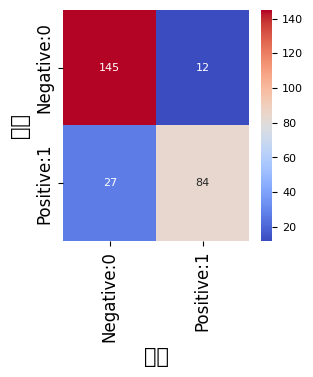

In [ ]:
### 混合行列の可視化
# cm = confusion_matrix(y_valid,y_pred)
cm = confusion_matrix(y_pred=y_pred,y_true=y_valid)
heat_map(cm)
plt.xticks(rotation=90)
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

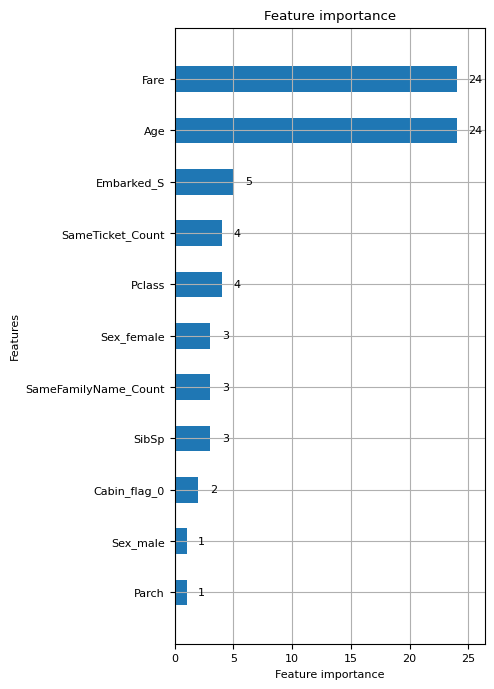

In [ ]:
### 特徴量重要度の可視化
plt.rcParams["font.size"] = 8
lgb.plot_importance(model, height = 0.5, figsize = (4,8),)

In [39]:
### 予測の実行
pred_test = model.predict(test_x, num_iteration=model.best_iteration)
y_pred_test = np.where(pred_test < 0.5, 0, 1)

In [45]:
y_test_df = pd.DataFrame(y_pred_test, columns=['Survived'])

In [46]:
result_df = pd.concat([test_data['PassengerId'], y_test_df], axis=1)

In [51]:
result_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [52]:
result_df.to_csv('processed_data/' + result_file, index=False)